In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

## Python program to understand the usage of tabulate function for printing tables in a tabular format
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

from matplotlib.pyplot import figure
figure(figsize=(10, 10), dpi=100)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

# **About the dataset**

This dataset is taken from kaggle, it is hierarchical sales data from Walmart, the world’s largest company by revenue, used to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to work on and improve forecasting accuracy.

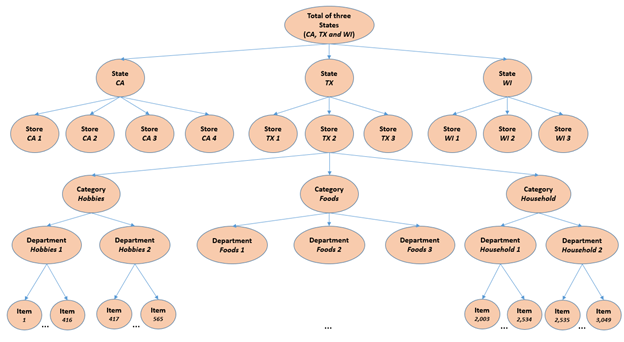

In [3]:
import pandas as pd

root_path = 'gdrive/My Drive/m5-forecasting-accuracy/' 
sales_train_validation = pd.read_csv(root_path + "sales_train_validation.csv")
calendar = pd.read_csv(root_path + "calendar.csv")

data = []
dfs = {"sales_train_validation": sales_train_validation, "calendar": calendar}
for df in dfs:
  data.append([df, dfs[df].shape, dfs[df].columns[dfs[df].isnull().any()].tolist(), list(dfs[df].columns)])

print(tabulate(data, headers=["Dataframe Name", "Shape", "List of columns with NaNs", "List of columns"])) 

Dataframe Name          Shape          List of columns with NaNs                                         List of columns
----------------------  -------------  ----------------------------------------------------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [4]:
data = []
for level in ["state_id", "store_id", "cat_id", "dept_id", "item_id"]:
  data.append([level, sales_train_validation[level].nunique(), list(sales_train_validation[level].unique())])

print(tabulate(data, headers=["Level", "No. Of Unique Values", "Unique Values"])) 
days = [i for i in sales_train_validation.columns.values if 'd_' in i]
print("There are {} days worth of data in training + validation set, which is approximately {} years".format(len(days), len(days)//365))

Level       No. Of Unique Values  Unique Values
--------  ----------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
calendar.describe()

,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,11347.086338,3.997461,6.325546,2013.288471,0.330117,0.330117,0.330117
std,155.277043,2.001141,3.416864,1.580198,0.470374,0.470374,0.470374
min,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,11219.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,11337.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,11502.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,11621.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000


snap_CA, snap_TX, snap_WI indicate whether snap purchases were allowed on
that day for that region, 1 means allowed.

What is SNAP Program –
The United States federal government provides a nutrition assistance benefit
called the Supplemental Nutrition Assistance Program (SNAP). SNAP provides
low income families and individuals with an Electronic Benefits Transfer debit
card to purchase food products. In many states, the monetary benefits are
dispersed to people across 10 days of the month and on each of these days 1/10
of the people will receive the benefit on their card. More information about the
SNAP program can be found

In [6]:
sales_train_validation["total_unit_sales"] = sales_train_validation.iloc[:, 6:].sum(axis=1)
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,total_unit_sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1,600
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,493
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1,288
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2,3288
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4,1849


In [7]:
def create_bar_plot(cat1, cat2):
  sales_train_validation.groupby([cat1, cat2]).total_unit_sales.mean().unstack(0).plot(kind="bar", figsize=(8, 8), alpha=0.65, rot=0)
  plt.ticklabel_format(style='plain', axis='y') # to prevent the plot from displaying numbers in exponential
  plt.ylabel('total_unit_sales')
  plt.show()

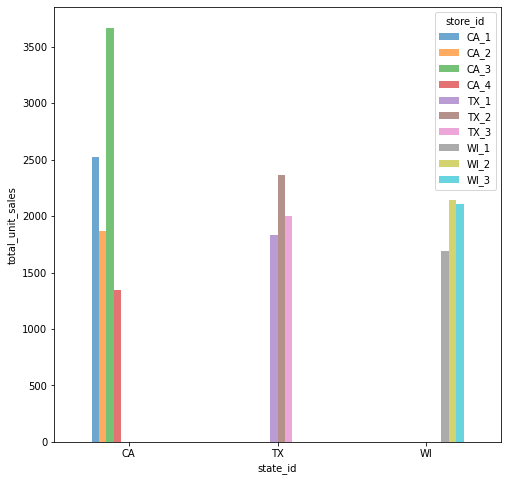

In [8]:
create_bar_plot("store_id", "state_id")

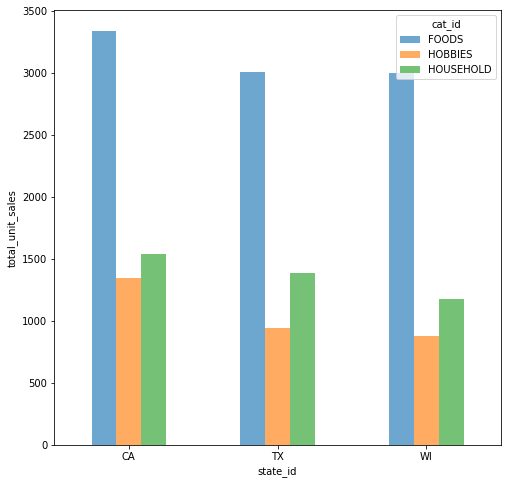

In [9]:
create_bar_plot("cat_id", "state_id")

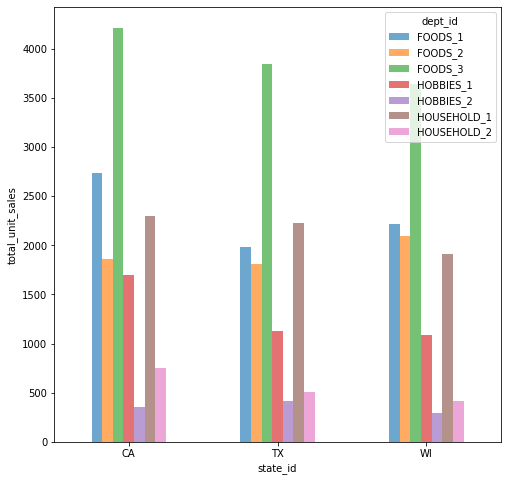

In [10]:
create_bar_plot("dept_id", "state_id")

We can see that the average sales in California are higher than the sales in Texas and Wisconsin

It is important to note that the sales vary alot across different categories

In [11]:
# Since the Sales CSV has data only for about 1941 days, we are picking the date for 1941 days from Cal CSV.
date = calendar.loc[:1912, 'date']

# Before plotting the chart for total sales every day across all the states, we are creating a Data Frame making it convinent to plot
temp = pd.DataFrame({'Date': date, "Total Sales": sales_train_validation[days].sum(axis=0).values})

# Using plotly line plot to make it interactive
fig = px.line(data_frame=temp, x="Date", y="Total Sales")

# The tilte parameter sets the title for the chart and title_x = 0.5 brings it to center, the value ranges between 0 - 1.
fig.update_layout(title='Total Sales', title_x=0.5)
fig.show()

We can see a dip in sales towards the end of each year, which can be explained by Christmas and New Years holidays

In [12]:
def create_plot(cat, title, x_axis, y_axis, from_=0, to=None):
    """This function diplays the plot by grouping the sales based on the passed category with the sales made every month.

        cat - The feature/column we need to group the items
        title - The title name for the chart
        x_axis - The name of the X-axis
        y_axis - The name of the Y-axis"""

# As we have defined the date outside the function and calling it as a local variable inside the function, we need to define it as global to be used so.
    global date

# We are grouping all the items by it's categories and summing up it's sales on each day. Then making a transpose to make it easy for plot.
    temp = sales_train_validation.drop("total_unit_sales", 1).groupby(cat).sum().T

# We are creating a date variable to group all the data based on the montly sales, as daily sales chart will a lot of Jitters.
# Thus from the cal csv we are picking the date feature and reforming from dd-mm-yyyy to ddmmyyyy.
    date = ["".join(str(i).split('-')[:2]) for i in date]

# Since we are working on a csv file we downcasted, all the columns/features names have been converted to different dtype, hence we are converting it back to string, 
# before adding a new feature, which is not downcasted. This below line is not required if we are working on csv which is not downcasted.
    temp.columns = temp.columns.astype(str)

# Now we are adding the date feature we obtained to the sales csv
    temp['Date'] = date

# Then we are summing up the data to montly view, since we had it previouly summed it to every day.
    temp = temp.groupby("Date").sum() 
    x_dates = [d for d in pd.date_range(start = '2011-01-01', end = '2016-04-04', freq = 'MS')]
    fig = go.Figure()
    for i in temp.columns[from_:to]:
        fig.add_trace(go.Scatter(x = x_dates, y = temp[i], mode='lines', name=i))
    fig.update_layout(title=title, title_x=0.5, xaxis_title=x_axis,yaxis_title=y_axis, width=1000)
    fig.show()

In [13]:
create_plot(cat='state_id', title='Yearly Sales Per State', x_axis='Year', y_axis='Sales')

In [14]:
create_plot(cat='store_id', title='Yearly Sales Per Store', x_axis='Year', y_axis='Sales')

In [15]:
create_plot(cat='cat_id', title='Yearly Sales Per Category', x_axis='Year', y_axis='Sales')

In [16]:
create_plot(cat='dept_id', title='Yearly Sales Per Department', x_axis='Year', y_axis='Sales')